In [8]:
from config import Config
from monai.transforms import ( Compose, LoadImaged, ToTensord, Spacingd, ScaleIntensityd, Resized, EnsureChannelFirstd )
from monai.transforms import ( LoadImage, EnsureChannelFirst, Spacing, ScaleIntensity, Resize, ToTensor)
from model.deepMATdeform import LitVoxel2MAT
from monai.data import Dataset, DataLoader
from monai.utils import first
from utils.file_handle import write_ma
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from matplotlib import interactive
%matplotlib notebook


ImportError: Failed to import any of the following Qt binding modules: PyQt6, PySide6, PyQt5, PySide2

In [2]:
cfg = Config()
keys = ['image', 'label']
transform = Compose([
    LoadImaged(keys=keys),
    EnsureChannelFirstd(keys=keys),
    Spacingd(keys=keys, pixdim=(1.25, 1.25, 1.25)),
    ScaleIntensityd(keys=keys, minv=0.0, maxv=1.0),
    Resized(keys=keys, spatial_size=cfg.resize_shape),
    ToTensord(keys=keys)
 ])
image_name = "\\Users\\rick\\Documents\\datasets\\Task02_Heart\\imagesTr\\la_003.nii.gz"
label_name = "\\Users\\rick\\Documents\\datasets\\Task02_Heart\\labelsTr\\la_003.nii.gz"
subject_dict = [{"image": image_name, "label": label_name}]
dataset = Dataset(subject_dict, transform)
dataloader = DataLoader(dataset, batch_size=cfg.batch_size, num_workers=0, pin_memory=True)

model = LitVoxel2MAT.load_from_checkpoint("\\Users\\rick\\Documents\\Projects\\models_waights_heart\\epoch=76-val_loss=170.15.ckpt", config=cfg)
model.eval()
x = first(dataloader)
voxel_pred, MAT_deformed = model(x['image'].to(model.device))
mask = (torch.argmax(F.softmax(voxel_pred, dim=1), dim=1)).squeeze(0)

def multi_slice_viewer(volume):
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

original_image = x['image'].squeeze()
expected_mask = x['label'].squeeze()
evaluated_mask = mask.cpu().squeeze()

c:\Users\rick\miniconda3\envs\DMD\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


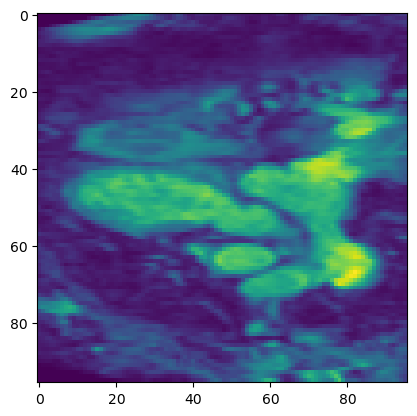

In [5]:
multi_slice_viewer(original_image)

In [ ]:

vertices = MAT_deformed[-1]
skel_xyzr = vertices
skel_xyz = skel_xyzr[:, :, :-1].cpu().squeeze()
skel_radius = skel_xyzr[:, :, -1].cpu().squeeze()

mat_edges = model.mat_edges.cpu().squeeze()
mat_faces = model.mat_faces.cpu().squeeze()
write_ma('test.ma', skel_xyz, skel_radius, mat_edges, mat_faces)